In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [6]:
def d_depth_proj_ev(depth_and_seed_ops, size, Hamiltonian, temp, ts,
                    observables, visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_proj_ev = time.time()
    K_ref, rho_ref = me.build_reference_state(temp = temp_ref, 
                                              Hamiltonian = Hamiltonian,
                                              lagrange_op = cl_ops["n_oc_disp"], 
                                              lagrange_mult = .5)
    
    basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=Hamiltonian, 
                                                    rho0=rho_ref)
    
    basis_orth = me.base_orth(ops = basis_incursive, 
                              rho0 = rho_ref, 
                              sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
    
    print("using a base of size ", len(basis_orth))
    print("rho_ref: ", rho_ref)
    
    ### test 2
    me.basis_orthonormality_check(basis = basis_orth, 
                                  rho0 = rho_ref, 
                                  sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth, temp=temp)
    Hijtensor = me.H_ij_matrix(Hamiltonian = Hamiltonian,
                               basis = basis_orth, 
                               rho0 = rho_ref, 
                               sc_prod = me.HS_inner_prod_r)
   
    ### constructing the coefficient arrays and the physical states
    res_proj_ev_rhot_list, phit = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, 
                                                     Htensor = Hijtensor, ts = ts, basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = res_proj_ev_rhot_list, 
                                           visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in res_proj_ev_rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_proj_ev)
    
    ### Exact solution 
    
    start_time_exact = time.time()
    res_exact = me.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops=observables)
    
    print("Exact ev runtime = ", time.time() - start_time_exact)
    
    if visualize_expt_vals:
        me.plot_exact_v_proj_ev_avgs(observables, label_ops, ts, res_proj_ev, res_exact)
        label_metric = ["Bures Exact v. Proj ev", "S(exact || proj_ev)", "S(proj_ev || exact)"]
        me.plot_exact_v_proj_ev_metrics(ts, res_proj_ev_rhot_list, res_exact, label_metric)
    
    return rho0, res_proj_ev_rhot_list, res_exact, res_proj_ev, basis_orth, phit

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]
43


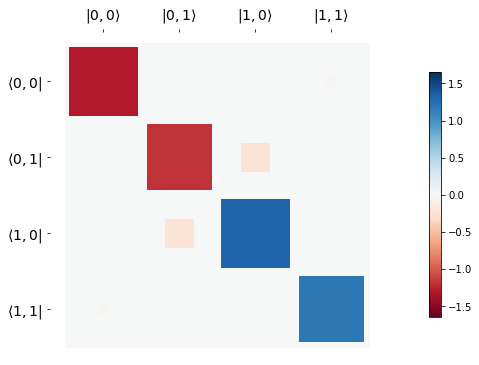

In [14]:
N=2; k_B = 1; temp = 1e-2; temp_ref = 2.;
chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]

### construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 150,1200)  

### Heisenberg Hamiltonian & classical operators
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = True)

#rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
#sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

### Base completa

zero_body_ops = spin_ops_list[0]
one_body_ops = [op for op in spin_ops_list[1]+spin_ops_list[2]+spin_ops_list[3]]
two_body_ops = [op1 * op2 for op1 in one_body_ops for op2 in one_body_ops]
depth_and_seed_ops = [(3,op) for op in (zero_body_ops+one_body_ops+two_body_ops)]
print(len(depth_and_seed_ops))

using a base of size  16
rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.445 0.0 0.0 0.004]
 [0.0 0.41400000000000003 0.026000000000000002 0.0]
 [0.0 0.026000000000000002 0.067 0.0]
 [0.004 0.0 0.0 0.07200000000000001]]
The basis is orthonormal and hermitian


Proj ev runtime =  13.34273076057434
Exact ev runtime =  0.32724928855895996


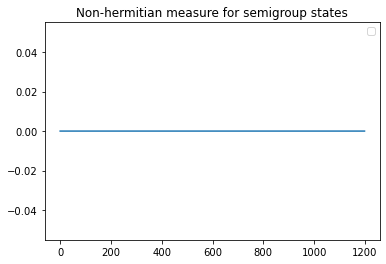

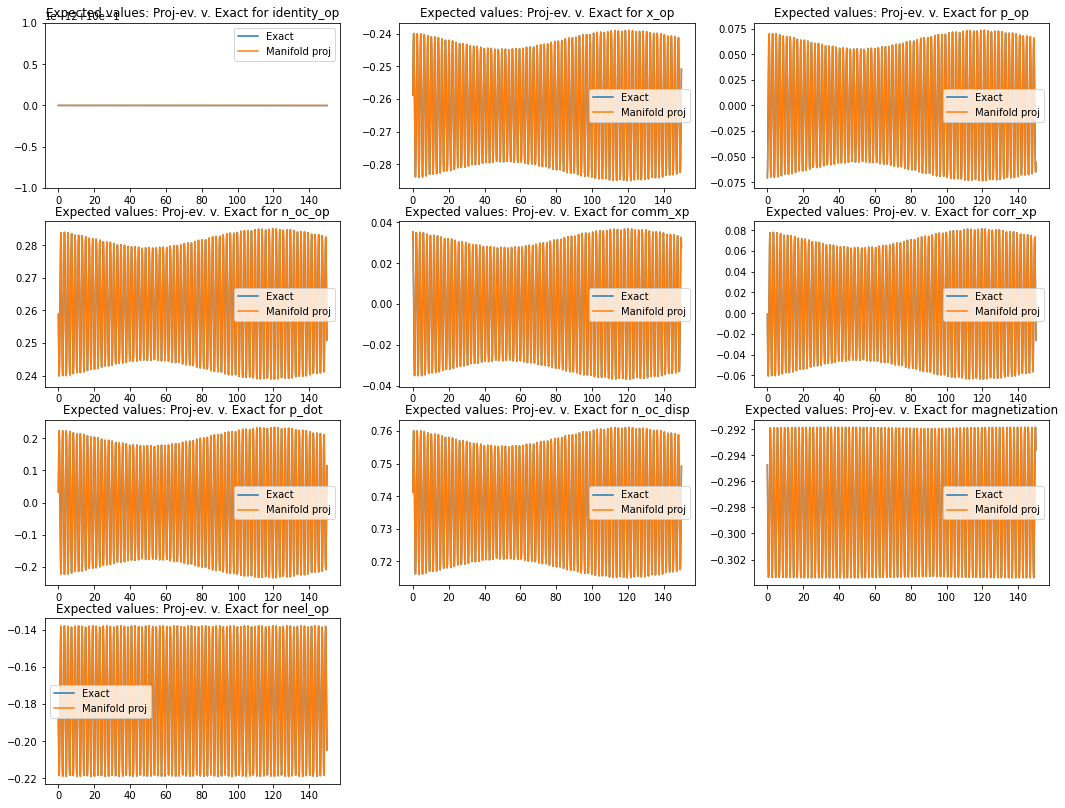

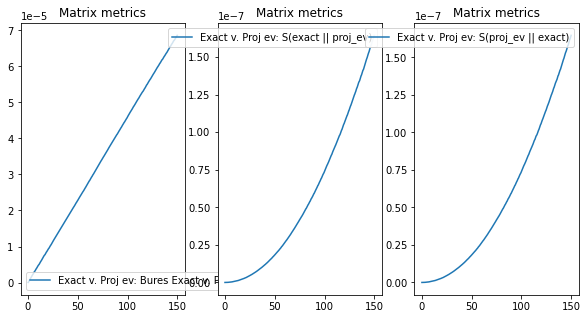

In [15]:
observables = list(cl_ops.values())
rho0, herm_rhot_list, res_exact, res_proj_ev, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    temp = 1., ts = ts,
    observables = observables, 
    visualize_H_evs = False, visualization_nonherm = True, visualize_expt_vals = True
)

Notar que la entropía del estado "exacto" no es constante, sino que crece, mientras que la del estado aproximado oscila. La amplitud de las oscilaciones parece depender de delta t. Al hacer el paso más pequeño, la fluctuación disminuye. Lo mismo ocurre con las distancias entre el estado exacto y el aproximado.

## Base superficial para x y p

using a base of size  4
rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.52 0.0 0.0 0.005]
 [0.0 0.451 0.033 0.0]
 [0.0 0.033 0.013000000000000001 0.0]
 [0.005 0.0 0.0 0.013000000000000001]]
The basis is orthonormal and hermitian
Proj ev runtime =  1.1916208267211914
Exact ev runtime =  0.05129551887512207


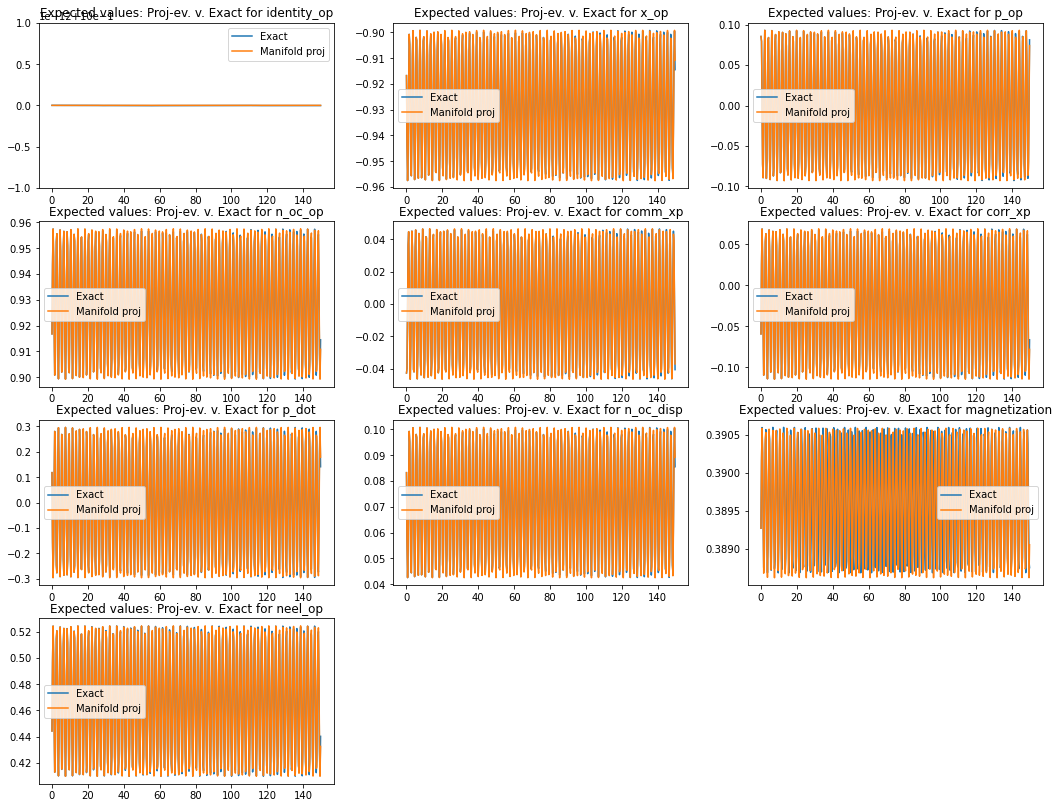

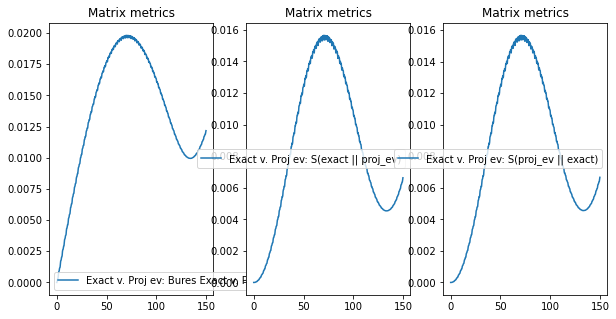

In [41]:
N = 2; k_B = 1; 
temp = 10.           # Temperatura para el estado inicial
temp_ref=1.       # Temperatura para el estado de referencia
ts = np.linspace(0, 150,500)  # Tiempos a barrer

depth_and_seed_ops_NG = [(1, cl_ops["identity_op"]),
                      (3, cl_ops["x_op"]),
                      #(1, cl_ops["p_op"]),
                      #(1, cl_ops["corr_xp"]),
                      #(1, cl_ops["p_dot"]),
                      #(1, cl_ops["x_op"]),
                      #(1, cl_ops["magnetization"])
                      #(1, cl_ops["neel_op"])
                     ]
observables = list(cl_ops.values())

rho0, herm_rhot_list, res_exact, res_proj_ev, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops_NG,
    size = N,
    Hamiltonian = H_H, 
    temp = 1., ts = ts,
    observables = observables, 
    visualize_H_evs = False, visualization_nonherm = False, visualize_expt_vals = True
)

En este caso, al no trabajar con la base completa, el observable de magnetización (la ocupación) se empieza a correr respecto al exacto. Las frecuencias de oscilación se mantienen practicamente iguales que en el caso exacto.

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations